# Max Entropy Model for Sentiment Analysis

In this notebook, we implement a Max Entropy (MaxEnt) model to perform sentiment analysis on textual data. This task is part of the CO3117 Machine Learning project, focusing on comparing several ML models across a unified use case.

**Use Case**: Sentiment classification (positive vs. negative)  
**Dataset**: [Twitter and Reddit Sentimental Analysis Dataset](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset)  

The dataset combines tweets and Reddit comments labeled as either positive or negative. To enhance preprocessing and feature extraction, we also leverage the following external resource:

- **Text-cleaning patterns**: A dictionnary of common internet abbreviations and custom cleaning functions adapted from this [Kaggle notebook](https://www.kaggle.com/code/vshantam/twitter-and-reddit-sentiments-lstm-embeddings)

This notebook is divided in 4 parts :
- 1) Setup and Imports
- 2) Data Preprocessing
- 3) MaxEnt Model Training and Hyperparameter Tuning
- 4) Results Analysis & Most Influent Features


## 1. Setup and Imports

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words("english"))
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


## 2. Data Preprocessing
### a) Loading the data

In [10]:
# Loading the data
df_reddit = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
df_twitter = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')

In [11]:
# Merging the twitter and reddit data into one dataset
df_twitter.rename(columns = {'clean_text':'clean_comment'}, inplace = True) # renaming the twitter columns like the reddit columns
print("Twitter dataset shape : ", df_twitter.shape,"\nReddit dataset shape : ",  df_reddit.shape)
#df = df_reddit.append(df_twitter).reset_index()
df = pd.concat([df_reddit, df_twitter], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffling the reddit comments and tweets
print("Merged dataset shape : ", df.shape)
print(df.head())

Twitter dataset shape :  (162980, 2) 
Reddit dataset shape :  (37249, 2)
Merged dataset shape :  (200229, 2)
                                       clean_comment  category
0  seems like modi has given ahead will keep hot ...       1.0
1  those who are asking lakhs from modi kindly wa...       1.0
2  “chowkidar” tejasvi surya general secretary bj...       1.0
3  air india boarding pass with modi’ photo kicks...       0.0
4  congress led upa surgical strike dont air stri...       0.0


### b) Cleaning the data

In this section, we will clean the text to remove as much noise as possible.  
We will apply several preprocessing functions to:

- Remove URLs, ASCII characters, and other irrelevant symbols,
- Replace abbreviations with their full word equivalents.
- Apply stemming and lemmatization

In [12]:
# Dictionnary of all abbreviations we're going to use for the cleaning
abbreviations = {"$" : " dollar ","€" : " euro ","4ao" : "for adults only","a.m" : "before midday",
    "a3" : "anytime anywhere anyplace","aamof" : "as a matter of fact","acct" : "account",
    "adih" : "another day in hell","afaic" : "as far as i am concerned","afaict" : "as far as i can tell","afaik" : "as far as i know",
    "afair" : "as far as i remember","afk" : "away from keyboard","app" : "application",
    "approx" : "approximately","apps" : "applications","asap" : "as soon as possible","asl" : "age, sex, location","atk" : "at the keyboard",
    "ave." : "avenue","aymm" : "are you my mother","ayor" : "at your own risk", "b&b" : "bed and breakfast","b+b" : "bed and breakfast","b.c" : "before christ",
    "b2b" : "business to business","b2c" : "business to customer","b4" : "before","b4n" : "bye for now",
    "b@u" : "back at you","bae" : "before anyone else","bak" : "back at keyboard","bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation","bbias" : "be back in a second","bbl" : "be back later","bbs" : "be back soon",
    "be4" : "before","bfn" : "bye for now","blvd" : "boulevard","bout" : "about","brb" : "be right back",
    "bros" : "brothers","brt" : "be right there","bsaaw" : "big smile and a wink","btw" : "by the way",
    "bwl" : "bursting with laughter","c/o" : "care of","cet" : "central european time","cf" : "compare",
    "cia" : "central intelligence agency","csl" : "can not stop laughing","cu" : "see you","cul8r" : "see you later",
    "cv" : "curriculum vitae","cwot" : "complete waste of time","cya" : "see you","cyt" : "see you tomorrow",
    "dae" : "does anyone else","dbmib" : "do not bother me i am busy","diy" : "do it yourself","dm" : "direct message",
    "dwh" : "during work hours","e123" : "easy as one two three",
    "eet" : "eastern european time","eg" : "example","embm" : "early morning business meeting","encl" : "enclosed",
    "encl." : "enclosed","etc" : "and so on","faq" : "frequently asked questions","fawc" : "for anyone who cares","fb" : "facebook",
    "fc" : "fingers crossed","fig" : "figure","fimh" : "forever in my heart", "ft." : "feet",
    "ft" : "featuring","ftl" : "for the loss","ftw" : "for the win","fwiw" : "for what it is worth",
    "fyi" : "for your information","g9" : "genius","gahoy" : "get a hold of yourself","gal" : "get a life",
    "gcse" : "general certificate of secondary education","gfn" : "gone for now","gg" : "good game",
    "gl" : "good luck","glhf" : "good luck have fun","gmt" : "greenwich mean time","gmta" : "great minds think alike",
    "gn" : "good night","g.o.a.t" : "greatest of all time","goat" : "greatest of all time",
    "goi" : "get over it","gps" : "global positioning system","gr8" : "great","gratz" : "congratulations",
    "gyal" : "girl","h&c" : "hot and cold","hp" : "horsepower","hr" : "hour","hrh" : "his royal highness",
    "ht" : "height","ibrb" : "i will be right back","ic" : "i see","icq" : "i seek you","icymi" : "in case you missed it",
    "idc" : "i do not care","idgadf" : "i do not give a damn fuck","idgaf" : "i do not give a fuck","idk" : "i do not know",
    "ie" : "that is","i.e" : "that is","ifyp" : "i feel your pain","IG" : "instagram","iirc" : "if i remember correctly","ilu" : "i love you",
    "ily" : "i love you","imho" : "in my humble opinion","imo" : "in my opinion","imu" : "i miss you","iow" : "in other words",
    "irl" : "in real life","j4f" : "just for fun","jic" : "just in case","jk" : "just kidding","jsyk" : "just so you know",
    "l8r" : "later","lb" : "pound","lbs" : "pounds","ldr" : "long distance relationship","lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off","lol" : "laughing out loud","ltd" : "limited","ltns" : "long time no see","m8" : "mate",
    "mf" : "motherfucker","mfs" : "motherfuckers","mfw" : "my face when","mofo" : "motherfucker","mph" : "miles per hour",
    "mr" : "mister","mrw" : "my reaction when","ms" : "miss","mte" : "my thoughts exactly","nagi" : "not a good idea",
    "nbc" : "national broadcasting company","nbd" : "not big deal","nfs" : "not for sale","ngl" : "not going to lie","nhs" : "national health service",
    "nrn" : "no reply necessary","nsfl" : "not safe for life","nsfw" : "not safe for work","nth" : "nice to have","nvr" : "never",
    "nyc" : "new york city","oc" : "original content","og" : "original","ohp" : "overhead projector","oic" : "oh i see",
    "omdb" : "over my dead body","omg" : "oh my god","omw" : "on my way","p.a" : "per annum","p.m" : "after midday","pm" : "prime minister",
    "poc" : "people of color","pov" : "point of view","pp" : "pages","ppl" : "people","prw" : "parents are watching","ps" : "postscript",
    "pt" : "point","ptb" : "please text back","pto" : "please turn over","qpsa" : "what happens","ratchet" : "rude",
    "rbtl" : "read between the lines","rlrt" : "real life retweet", "rofl" : "rolling on the floor laughing","roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off","rt" : "retweet","ruok" : "are you ok","sfw" : "safe for work","sk8" : "skate",
    "smh" : "shake my head","sq" : "square","srsly" : "seriously", "ssdd" : "same stuff different day","tbh" : "to be honest","tbs" : "tablespooful",
    "tbsp" : "tablespooful","tfw" : "that feeling when","thks" : "thank you","tho" : "though","thx" : "thank you",
    "tia" : "thanks in advance","til" : "today i learned","tl;dr" : "too long i did not read","tldr" : "too long i did not read","tmb" : "tweet me back",
    "tntl" : "trying not to laugh","ttyl" : "talk to you later","u" : "you","u2" : "you too","u4e" : "yours for ever","utc" : "coordinated universal time","w/" : "with",
    "w/o" : "without","w8" : "wait","wassup" : "what is up","wb" : "welcome back","wtf" : "what the fuck","wtg" : "way to go",
    "wtpa" : "where the party at","wuf" : "where are you from","wuzup" : "what is up","wywh" : "wish you were here",
    "yd" : "yard","ygtr" : "you got that right","ynk" : "you never know","zzz" : "sleeping bored and tired"
}

##### Below are all the functions we will use to clean the text :

In [13]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    words = text.split()
    return ' '.join([abbreviations.get(word.lower(), word) for word in words])

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [14]:
# Function combining all the previous cleaning functions
def clean_text(text):
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    # Remove  smileys
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    # Remove numbers and mentions
    text = remove_mention(text)
    text = remove_number(text)
    # Replace abbreviations
    text = replace_abbrev(text)
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)
    # Remove stopwords + lemmatization
    text = remove_stopwords(text)
    text = lemmatization(text)
    text = stemming(text)
    text = text.lower()
    return text

# We apply the function we just defined to clean the data
df['clean_comment'] = df['clean_comment'].apply(clean_text)

# Removing the misclassified data, and the empty data (because the stopwords removal may have
# turned previously complete sentences into empty ones).
before = len(df)
df = df[df['category'].isin([-1.0, 0.0, 1.0]) & (df['clean_comment'].str.len() > 0)]

after = len(df)
print(f"{before - after} comments were removed because they were either not properly classified or empty.")

print("\nExample of cleaned data :\n", df.head())

344 comments were removed because they were either not properly classified or empty.

Example of cleaned data :
                                        clean_comment  category
0       seem like modi give ahead keep hot april may       1.0
1  ask lakh modi kindli watch video promis lakh t...       1.0
2  chowkidar tejasvi surya gener secretari bjp yo...       1.0
3  air india board pass modi photo kick row later...       0.0
4  congress lead upa surgic strike dont air strik...       0.0


##### We can then check in details what the most common words are, and what is the categories distribution.

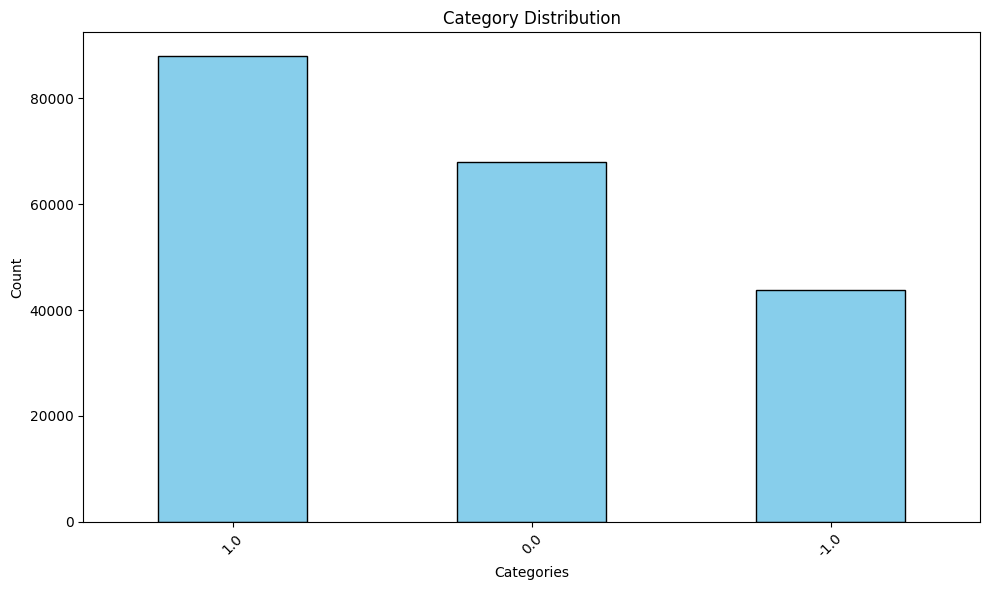

In [15]:
# Count the occurences of each category
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### We can see that the categories are not equal in size, which may ressult in errors/inacuracies during the training/test of our model.

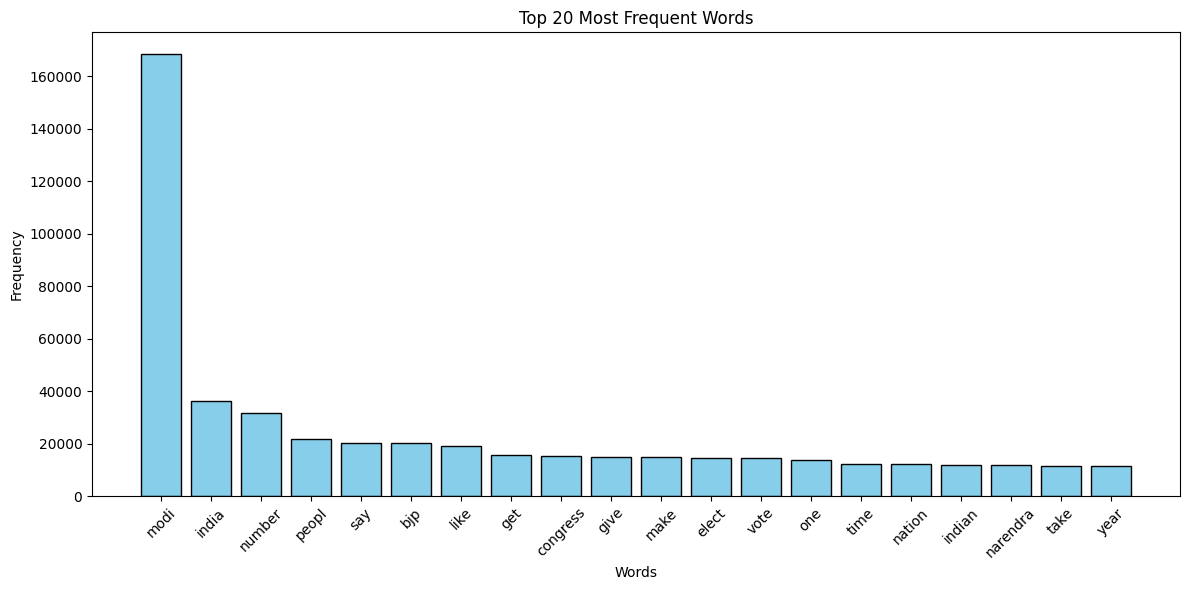

In [16]:
from collections import Counter

all_words = ' '.join(df['clean_comment']).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Split the words and their frequency
words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. MaxEnt Model Training and Hyperparameter Tuning

We train a Maximum Entropy (multinomial logistic regression) classifier using TF-IDF features extracted from the cleaned text. The vectorizer is limited to 5000 features to control dimensionality.

To improve generalization, we perform a grid search over the regularization strength `C` using 5-fold cross-validation. The best model is then retrained on the training set and evaluated on the held-out test set.

This approach allows us to fine-tune the model's complexity and avoid underfitting or overfitting.


In [18]:
# Vectorization of cleaned texts
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_comment'])

# target
y = df['category']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Hyperparameter search via cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        penalty='l2',
        max_iter=3000
    ),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Model training with search
grid.fit(X_train, y_train)

# Search results
print("Best hyperparameters:", grid.best_params_)
print("Best cross-validated F1-score:", grid.best_score_)

# Best model found
model = grid.best_estimator_

# Predictions on the test set
y_pred = model.predict(X_test)

Best hyperparameters: {'C': 10}
Best cross-validated F1-score: 0.8357127512428569


## 4. Results Analysis & Most Influent Features

In [19]:
# Evaluation
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

        -1.0       0.82      0.74      0.78      8777
         0.0       0.84      0.91      0.87     13606
         1.0       0.88      0.86      0.87     17594

    accuracy                           0.85     39977
   macro avg       0.84      0.84      0.84     39977
weighted avg       0.85      0.85      0.85     39977



#### Model Evaluation Summary

The Maximum Entropy model achieves an overall accuracy of **85%** on the test set, with **balanced precision and recall** across all three sentiment classes.

- The **neutral class (0.0)** is greatly predicted, with an F1-score of **0.87**, likely due to its large representation in the dataset.
- The **positive class (1.0)** also performs strongly (F1-score also equal to **0.87**), with a slightly higher precision than recall.
- The **negative class (-1.0)** has the lowest recall (**0.74**), precision (**0.82**) and F1-score (**0.78**), suggesting that the model sometimes confuses negative comments with neutral or positive ones. This may be due to the lower representation of negative comments in the dataset.

Despite this, the model performs consistently well across all classes, as reflected by the **macro-average F1-score of 0.84**. These results indicate that the MaxEnt classifier is a strong baseline for sentence-level sentiment classification.


<Figure size 1000x800 with 0 Axes>

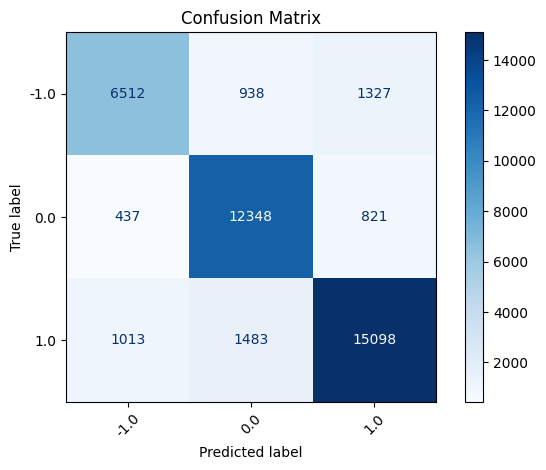

In [20]:
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#### Confusion Matrix Analysis

The confusion matrix provides detailed insight into the classification behavior of the MaxEnt model across the three sentiment classes :

- The **neutral class (0.0)** shows strong diagonal dominance with **12,348** correct predictions, confirming that the model distinguishes neutral content well. However, some confusion remains with both positive (**821**) and negative (**437**) classes.

- The **positive class (1.0)** is generally well predicted (**15,098** correct), though there are **1,483** neutral samples and **1,013** negative samples misclassified as positive. This indicates that the model sometimes overpredicts positivity, possibly due to overlapping vocabulary or optimistic tone in neutral/negative contexts.

- The **negative class (-1.0)** is the most challenging: **1,327** negative instances are predicted as positive, and **938** as neutral. This suggests a tendency of the model to underestimate negativity - possibly due to subtler (such as sarcasm) or less frequent linguistic signals of negative sentiment in the dataset.

Overall, the matrix confirms the trend observed in the classification report: **high performance on neutral and positive**, and **relatively lower recall for the negative class**, which may benefit from further class balancing or richer feature sets.


In [24]:

coef = model.coef_[0]
print("Top 15 most influential features (words) ranked by absolute weight :\n")
for feat, val in sorted(zip(vectorizer.get_feature_names_out(), coef), key=lambda x: -abs(x[1]))[:20]:
    print(f"{feat:15s} : {val:.3f}")


Top 15 most influential features (words) ranked by absolute weight :

hate            : 14.441
bad             : 13.659
worst           : 12.927
stupid          : 12.380
idiot           : 12.254
best            : -11.945
pathet          : 11.557
hard            : 11.088
fals            : 10.782
moron           : 10.733
poor            : 10.690
fake            : 10.512
disgust         : 10.402
black           : 10.196
terribl         : 10.151
wrong           : 10.079
afraid          : 9.914
fail            : 9.849
crap            : 9.831
bloodi          : 9.579


#### Feature Importance Analysis

By inspecting the coefficients learned by the Maximum Entropy model, we can identify the most influential features driving the classification decisions.

The highest-weighted words are overwhelmingly associated with **negative sentiment**, including *hate*, *bad*, *worst*, *stupid*, *idiot*, *moron*, and *fake*. These are highly polarized terms that strongly indicate negativity in user-generated content.

Interestingly, the feature *best* appears with a strong **negative coefficient** (−11.945), which reflects the model's internal encoding for class `-1.0` (negative): in scikit-learn’s multiclass setting, each row of `coef_` corresponds to a specific class. This means *best* is a strong negative indicator **against** class `-1.0`, and thus likely contributes to **positive classification** when absent from the negative class.

Other notable terms like *pathet(ic)*, *disgust*, *terribl(e)*, and *fail* reinforce the model's reliance on emotionally charged vocabulary.

Overall, the MaxEnt model behaves as expected by leveraging explicit lexical cues of sentiment, although its performance may be limited in more subtle or context-dependent expressions where these terms are absent.
